In [1]:
from functools import partial
import os
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.model_selection, sklearn.linear_model
from tqdm.contrib.concurrent import process_map

import postprocess
import utils

split_ratio_for_test = 0.3
split_ratio_for_postprocessing = 0.5  # among training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 43)

# This seed controls the randomness during pre-training (fixed)
seed_for_pretraining = 33

max_workers = 32

data_dir = "data/communities"

## Download UCI Communities and Crime dataset

In [2]:
features = [
    "state", "county", "community", "communityname", "fold", "population",
    "householdsize", "racepctblack", "racePctWhite", "racePctAsian",
    "racePctHisp", "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up",
    "numbUrban", "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf",
    "pctWInvInc", "pctWSocSec", "pctWPubAsst", "pctWRetire", "medFamInc",
    "perCapInc", "whitePerCap", "blackPerCap", "indianPerCap", "AsianPerCap",
    "OtherPerCap", "HispPerCap", "NumUnderPov", "PctPopUnderPov",
    "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore", "PctUnemployed",
    "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu",
    "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv",
    "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par",
    "PctYoungKids2Par", "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom",
    "NumIlleg", "PctIlleg", "NumImmig", "PctImmigRecent", "PctImmigRec5",
    "PctImmigRec8", "PctImmigRec10", "PctRecentImmig", "PctRecImmig5",
    "PctRecImmig8", "PctRecImmig10", "PctSpeakEnglOnly", "PctNotSpeakEnglWell",
    "PctLargHouseFam", "PctLargHouseOccup", "PersPerOccupHous",
    "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup",
    "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant",
    "PctHousOccup", "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos",
    "MedYrHousBuilt", "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart",
    "OwnOccMedVal", "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ",
    "MedRent", "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg",
    "NumInShelters", "NumStreet", "PctForeignBorn", "PctBornSameState",
    "PctSameHouse85", "PctSameCity85", "PctSameState85", "LemasSwornFT",
    "LemasSwFTPerPop", "LemasSwFTFieldOps", "LemasSwFTFieldPerPop",
    "LemasTotalReq", "LemasTotReqPerPop", "PolicReqPerOffic", "PolicPerPop",
    "RacialMatchCommPol", "PctPolicWhite", "PctPolicBlack", "PctPolicHisp",
    "PctPolicAsian", "PctPolicMinor", "OfficAssgnDrugUnits",
    "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea", "PopDens",
    "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr",
    "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop",
    "ViolentCrimesPerPop"
]

data_path = f"{data_dir}/communities.data"
if not os.path.exists(data_path):
  os.makedirs(data_dir, exist_ok=True)
  urllib.request.urlretrieve(
      "https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
      data_path)

original = pd.read_csv(data_path,
                       names=features,
                       sep=r",",
                       engine="python",
                       na_values="?")

# Drop community name, state, and county, and columns with missing values
original = original.drop(["communityname", "state", "county"],
                         axis=1).dropna(axis=1)

# Create 5 equidistance bins for ViolentCrimesPerPop column
labels_original = pd.cut(original["ViolentCrimesPerPop"], 5)

# Define a new sensitive attribute called "MinorityPresence"
minority_pct = np.stack([
    original[a].to_numpy()
    for a in ["racePctHisp", "racePctAsian", "racepctblack"]
],
                        axis=1)
minority_presence = np.array(["hispanic", "asian",
                              "black"])[minority_pct.argmax(axis=1)]
minority_presence[original["racePctWhite"] > 0.95] = "white"
original["MinorityPresence"] = minority_presence


def data_transform(df):
  """Normalize features."""
  binary_data = pd.get_dummies(df)
  scaler = sklearn.preprocessing.StandardScaler()
  data = pd.DataFrame(scaler.fit_transform(binary_data),
                      columns=binary_data.columns)
  data.index = df.index
  return data


# Transform data and encode labels as integers, and remove fold and target
data = original.copy()
data = data.drop(["ViolentCrimesPerPop", "fold"], axis=1)
data = data_transform(data)

label_names, labels = np.unique(labels_original, return_inverse=True)
n_classes = len(label_names)
group_names, groups = np.unique(original["MinorityPresence"],
                                return_inverse=True)
n_groups = len(group_names)

In [3]:
# Compute and print dataset statistics

df = pd.DataFrame(
    np.stack([original["MinorityPresence"], labels_original], axis=1),
    columns=["Group", "Target"],
)
df_grouped = df.groupby(["Target", "Group"]).size().unstack()
counts = df_grouped.sum(axis=0)

print("Dataset statistics:")
display(df_grouped / counts)
display(pd.DataFrame(counts, columns=["Count"]).T)

print("Perfect results if dataset equals population:")
display(
    pd.DataFrame([{
        "alpha":
            np.inf,
        "accuracy":
            1.0,
        "delta_dp":
            utils.delta_dp(labels, groups),
        "delta_dp_rms":
            utils.delta_dp(
                labels,
                groups,
                ord=2,
            ) / np.sqrt(n_classes)
    }, {
        "alpha":
            0.0,
        "accuracy":
            1 - postprocess.PostProcessorDP().fit(
                scores=np.concatenate(
                    [np.eye(n_classes) for _ in range(n_groups)], axis=0),
                groups=np.repeat(np.arange(n_groups), n_classes),
                sample_weight=np.nan_to_num(
                    (df_grouped.to_numpy() / counts.to_numpy())).T.flatten(),
            ).score_,
        "delta_dp":
            0.0,
        "delta_dp_rms":
            0.0
    }]).groupby('alpha').agg('mean').sort_index(ascending=False))

Dataset statistics:


Group,asian,black,hispanic,white
Target,,,,
"(-0.001, 0.2]",0.768683,0.340625,0.417323,0.922141
"(0.2, 0.4]",0.156584,0.279687,0.367454,0.060827
"(0.4, 0.6]",0.032028,0.185938,0.131234,0.012165
"(0.6, 0.8]",0.028470,0.092188,0.049869,0.002433
"(0.8, 1.0]",0.014235,0.101562,0.034121,0.002433


Group,asian,black,hispanic,white
Count,562,640,381,411


Perfect results if dataset equals population:


,accuracy,delta_dp,delta_dp_rms
alpha,,,
inf,1.000000,0.581516,0.294666
0.0,0.766781,0.000000,0.000000


In [4]:
(data_, train_data_pre, labels_, train_labels_pre, groups_,
 train_groups_pre) = sklearn.model_selection.train_test_split(
     data,
     labels,
     groups,
     test_size=(1 - split_ratio_for_test) *
     (1 - split_ratio_for_postprocessing),
     random_state=seed_for_pretraining,
 )

n_samples = len(data)
n_pre = len(train_data_pre)
n_test = int(n_samples * split_ratio_for_test)
n_post = n_samples - n_pre - n_test

## Train score function

In [5]:
# Train a logistic regression model on the pre-training data
predictor = sklearn.linear_model.LogisticRegression(
    random_state=seed_for_pretraining, max_iter=1000)
predictor.fit(train_data_pre, train_labels_pre)

# Get predicted probabilities
probas_ = predictor.predict_proba(data_)

## Post-process for demographic parity

  0%|          | 0/150 [00:00<?, ?it/s]

/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
/home/rxian/anaconda3/envs/fair/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


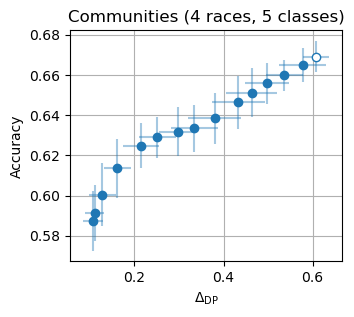

accuracy            delta_dp           delta_dp_rms          
           mean       std      mean       std         mean       std
alpha                                                               
inf    0.669231  0.007836  0.608146  0.029062     0.311143  0.013556
0.60   0.664883  0.008461  0.577270  0.053282     0.300307  0.021186
0.55   0.659866  0.007891  0.536605  0.040908     0.286066  0.017578
0.50   0.655853  0.010120  0.497439  0.049736     0.268140  0.028389
0.45   0.651171  0.012192  0.462936  0.056918     0.249829  0.034305
0.40   0.646488  0.013266  0.433499  0.060303     0.233707  0.035778
0.35   0.638462  0.012657  0.379768  0.059617     0.206661  0.033012
0.30   0.633445  0.011526  0.334265  0.053350     0.178365  0.027063
0.25   0.631773  0.012131  0.296767  0.042273     0.158801  0.019885
0.20   0.629097  0.010272  0.251256  0.041878     0.135181  0.017395
0.15   0.624916  0.011066  0.215004  0.040613     0.117767  0.014314
0.10   0.613545  0.014545  0.161247  0.029919     0.091943  0.013730
0.05   0.600502  0.015577  0.127975  0.030375     0.070228  0.018067
0.01   0.591304  0.013884  0.110446  0.021091     0.061845  0.013276
0.00   0.587291  0.014807  0.106697  0.023189     0.061303  0.011518

In [6]:
alphas = [
    np.inf, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05,
    0.01, 0.0
]

return_vals = process_map(
    partial(
        utils.postprocess,
        postprocessor_factory=postprocess.PostProcessorDP,
        evaluate_fn=partial(utils.evaluate,
                            n_groups=n_groups,
                            n_classes=n_classes,
                            metrics=['delta_dp', 'delta_dp_rms']),
        probas=probas_,
        labels=labels_,
        groups=groups_,
        n_post=n_post,
        n_test=n_test,
    ),
    [(alpha, seed) for alpha in alphas for seed in seeds],
    max_workers=max_workers,
)
results = [{
    'alpha': alpha,
    **result
} for alpha, _, result, _ in return_vals if result is not None]

(fig, ax), df = utils.plot_results(results, 'delta_dp')
ax.set_xlabel("$\\Delta_{\\mathrm{DP}}$")
ax.set_title("Communities (4 races, 5 classes)")
plt.show()
display(df)